# Visualizing the Philips Curve using matplotlib and altair

Our goal here is to empirically represent the Philips curve.
We import the data first using dbnomics, then use two different plotting libraries to construct the plots.

## Importing the Data

We start by loading library dbnomics. It is installed on the Nuvolos servers (just change the kernel to "ESCPython")

In [1]:
import dbnomics

The following code imports data for from dbnomics for a few countries.

In [2]:
table_1 = dbnomics.fetch_series([
    "OECD/DP_LIVE/FRA.CPI.TOT.AGRWTH.Q",
    "OECD/DP_LIVE/GBR.CPI.TOT.AGRWTH.Q",
    "OECD/DP_LIVE/USA.CPI.TOT.AGRWTH.Q",
    "OECD/DP_LIVE/DEU.CPI.TOT.AGRWTH.Q"
])

In [3]:
table_2 = dbnomics.fetch_series([
    "OECD/MEI/DEU.LRUNTTTT.STSA.Q",
    "OECD/MEI/FRA.LRUNTTTT.STSA.Q",
    "OECD/MEI/USA.LRUNTTTT.STSA.Q",
    "OECD/MEI/GBR.LRUNTTTT.STSA.Q"
])

__Describe concisely the data that has been imported (periodicity, type of measure, ...). You can either check dbnomics website or look at the databases.__

- table_1: 
    - growth of CPI index. The total of all goods. Quarterly data for France, UK, USA, Germany
- table_2
    - unemployment rate coming from LO

__Show the first rows of each database. Make a list of all columns.__

__Compute averages and standard deviations for unemployment and inflation, per country.__

In [4]:
# option 1: by using pandas boolean selection 

In [5]:
# option 2: by using groupby

__The following command merges the two databases together. Explain the role of argument `on`. What happened to the column names?__

In [6]:
table = table_1.merge(table_2, on=["period", 'Country']) 

The `on` argument indicate, which columns identify a unique observation. Here the date and the country denote the same observation in both countries.
However the column `value` of the first and the second database have a different meaning (resp `unemployment` and `inflation`). To distinguish them, they receive a suffix (`_x` and `_y` respectively).

We rename the new names for the sake of clarity and normalize everything with lower cases.

In [7]:
table = table.rename(columns={
    'period': 'date',         # because it sounds more natural
    'Country': 'country',
    'value_x': 'inflation',
    'value_y': 'unemployment'
})

__On the merged table, compute at once all the statistics computed before (use `groupby` and `agg`).__

In [32]:
table[['country','inflation', 'unemployment']].groupby('country').agg( [ 'mean', 'std'])

inflation           unemployment          
                    mean       std         mean       std
country                                                  
France          1.471232  1.097924     8.753655  0.951248
Germany         2.675258  1.857526     5.019525  3.083088
United Kingdom  5.352624  5.287619     6.757433  2.381173
United States   3.670127  2.791956     5.906965  1.658766

Before we process further, we should tidy the dataframe by keeping only what we need.
- Keep only the columns `date`, `country`, `inflation` and `unemployment`
- Drop all na values
- Make a copy of the result

In [9]:
df = table[['date', 'country', 'inflation', 'unemployment']].dropna()

In [10]:
df = df.copy()
# note: the copy() function is here to avoid keeping references to the original database

__What is the maximum availability interval for each country? How would you proceed to keep only those dates where all datas are available? In the following we keep the f__

Our DataFrame is now ready for further analysis !

## Plotting using matplotlib

Our goal now consists in plotting inflation against unemployment to see whether a pattern emerges. We will first work on France.

In [11]:
from matplotlib import pyplot as plt

__Create a database `df_fr` which contains only the data for France.__

In [12]:
df_fr = df[ df['country'] == 'France' ].copy() # again, we copy the result, because we plan to modify it

__The following command create a line plot for `inflation` against `unemployment`. Can you transform it into a scatterplot ?__

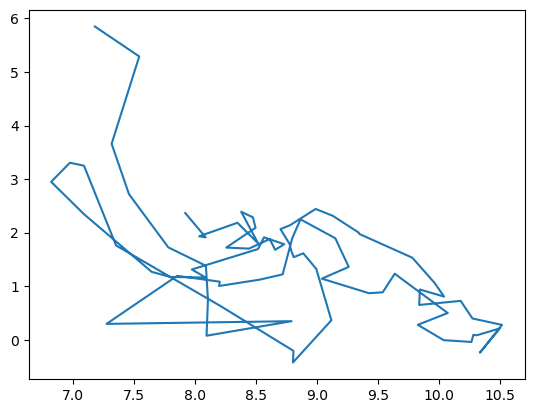

In [13]:
plt.plot(df_fr['unemployment'], df_fr['inflation']) # missing 'o'

__Expand the above command to make the plot nicer (label, title, grid, ...)__

The following piece of code regresses `inflation` on unemployment.

In [14]:
from statsmodels.formula import api as sm
model = sm.ols(formula='inflation ~ unemployment', data=df_fr)
result = model.fit()

We can use the resulting model to "predict" inflation from unemployment.

In [15]:
result.predict(df_fr['unemployment'])

0     2.061373
1     1.942585
2     1.980572
3     1.758155
4     1.638049
        ...   
74    2.159664
75    2.388158
76    2.489185
77    2.328699
78    2.586670
Length: 79, dtype: float64

__Store the result in df_fr as `reg_unemployment`__

In [16]:
df_fr['pred_inflation'] = result.predict(df_fr['unemployment'])

__By expanding again, the command above to make a plot, add the regression line to the scatter plot.__

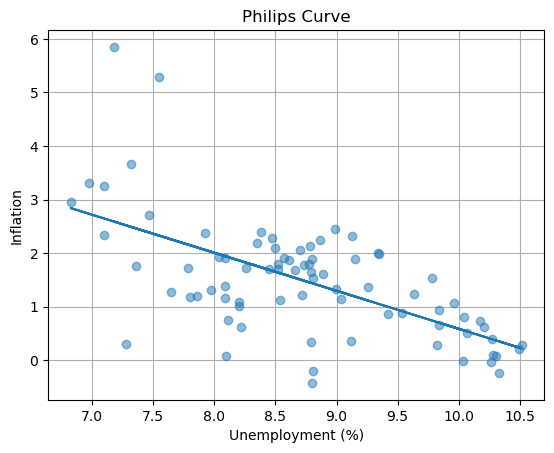

In [17]:
plt.plot(df_fr['unemployment'], df_fr['inflation'],'o', alpha=0.5)
plt.plot(df_fr['unemployment'], df_fr['pred_inflation'], color='C0')
plt.title("Philips Curve")
plt.xlabel("Unemployment (%)")
plt.ylabel("Inflation")
plt.grid()

__Now we would like to compare all countries. Can you find a way to represent the data for all of them (all on one graph, using subplots...) ?__

In [18]:
# this solution uses loops and iterators but the same can be done manually

In [19]:
countries = df['country'].unique()

In [20]:
df_countries = []
for c in countries:
    
    tmp = df[df['country']==c].copy()
    
    model = sm.ols(formula='inflation ~ unemployment', data=tmp)
    result = model.fit()
    
    tmp['pred_inflation'] = result.predict(tmp['unemployment'])

    df_countries.append(tmp)

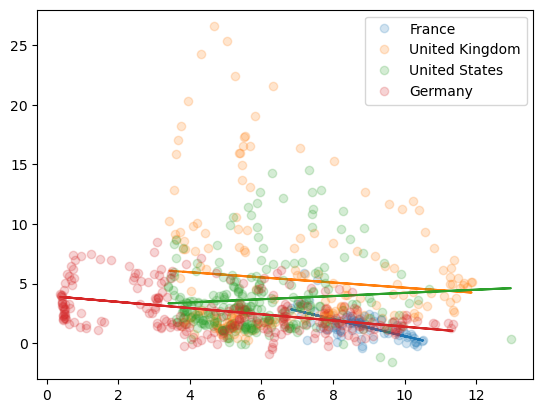

In [21]:
# all on one graph
for i, (d, c) in enumerate(zip(df_countries, countries)):
    plt.plot(d['unemployment'], d['inflation'], 'o', alpha=0.2, label=c, color=f"C{i}") # missing 'o'
    plt.plot(d['unemployment'], d['pred_inflation'],   color=f"C{i}") # missing 'o'
plt.legend(loc='upper right')

In [22]:
# using subplots

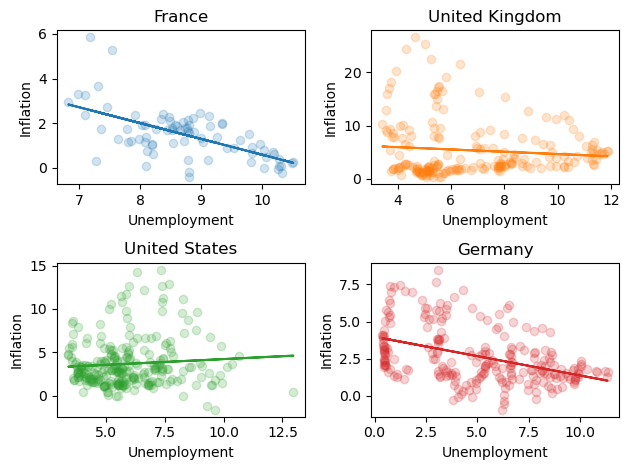

In [23]:
# all on one graph
fig = plt.subplots(2,2)
for i, (d, c) in enumerate(zip(df_countries, countries)):
    plt.subplot(2,2,i+1)
    plt.plot(d['unemployment'], d['inflation'], 'o', alpha=0.2, color=f"C{i}") # missing 'o'
    plt.plot(d['unemployment'], d['pred_inflation'],   color=f"C{i}") # missing 'o'
    plt.xlabel("Unemployment")
    plt.ylabel("Inflation")
    plt.title(c)
    plt.tight_layout()

__Any comment on these results?__

- First it would be nice to break the period into many subperiods. We know the story about the disappearnce of the Philips curve in the US (and the Lucas Critique).
- Second, there seems to be a strong contrast between US/UK and Germany/France. If one remembers the mechanisms behind the Philips curve it is not surprising: prices and wages are more rigid in Europe.
    - In the case of Germany, the conclusion is certainly not too strong: there has been a lot of volatility.
    - In the case of France, the time span of the time series is much smaller which also weakens the conclusion.

## Visualizing data using altair

Altair offers a different syntax to make plots. It is well adapted to the exploration phase, as it is able to operate on a full databse (without splitting it like we did for matplotlib). It also provides some data transformation tools like regressions, and ways to add some interactivity.

In [24]:
import altair as alt

__The following command makes a basic plot from the dataframe `df` which contains all the countries. Can you enhance it by providing a title and encoding information to distinguish the various countries?__

In [25]:
chart = alt.Chart(df).mark_point().encode(
    x='unemployment',
    y='inflation',
    # find a way to separate on the graph data from France and US
)
chart

/opt/conda/envs/escpython/lib/python3.10/site-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [26]:
# solution: 
chart = alt.Chart(df, title="Data for all countries").mark_point().encode(
    x='unemployment',
    y='inflation',
    color="country",
)
chart

alt.Chart(...)

__The following graph plots a regression line, but for all countries, it is rather meaningless. Can you restrict the data to France only?__

In [27]:
chart = alt.Chart(df).mark_point().encode(
    x='unemployment',
    y='inflation',
    # find a way to separate on the graph data from France and US
)
chart + chart.transform_regression('unemployment', 'inflation').mark_line()

alt.LayerChart(...)

In [28]:
# solution (it is also possible to replace df by df_fr...)
chart = alt.Chart(df).transform_filter('datum.country=="France"').mark_point().encode(
    x='unemployment',
    y='inflation',
    # find a way to separate on the graph data from France and US
)
chart + chart.transform_regression('unemployment', 'inflation').mark_line()

alt.LayerChart(...)

__One way to visualize data consists in adding some interactivity. Add some title and click on the legend__

In [29]:
multi = alt.selection_multi(fields=["country"])

legend = alt.Chart(df).mark_point().encode(
    y=alt.Y('country:N', axis=alt.Axis(orient='right')),
    color=alt.condition(multi, 'country:N', alt.value('lightgray'), legend=None)
).add_selection(multi)

chart_2 = alt.Chart(df).mark_point().encode(
    x='unemployment',
    y='inflation',
    color=alt.condition(multi, 'country:N', alt.value('lightgray')),
    # find a way to separate on the graph data from France and US
)

# chart + chart.transform_regression('unemployment', 'inflation').mark_line()


In [30]:
# Try to click on the legend
chart_2 | legend

alt.HConcatChart(...)

__Bonus question: in the following graph you can select an interval in the left panel to select some subsample. Can you add the regression line(s) corresponding to the selected data to the last graph?__

In [31]:
brush = alt.selection_interval(encodings=['x'],)

historical_chart_1 = alt.Chart(df).mark_line().encode(
    x='date',
    y='unemployment',
    color='country'
).add_selection(
    brush
)
historical_chart_2 = alt.Chart(df).mark_line().encode(
    x='date',
    y='inflation',
    color='country'
)
chart = alt.Chart(df).mark_point().encode(
    x='unemployment',
    y='inflation',
    # find a way to separate on the graph data from France and US
    color=alt.condition(brush, 'country:N', alt.value('lightgray'))
)
alt.hconcat(historical_chart_1, historical_chart_2, chart,)

alt.HConcatChart(...)

In [318]:
# TODO 